(cell_classification.object_classification)=
# 在OpenCL兼容GPU上进行对象分类
APOC基于[pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype)和[scikit-learn](https://scikit-learn.org/stable/)。它允许根据测量的属性/特征（如强度、形状和相邻细胞数量）对对象进行分类。

In [1]:
import apoc

from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import matplotlib.pyplot as plt

对于对象分类，我们需要一个强度图像和一个标签图像作为输入。

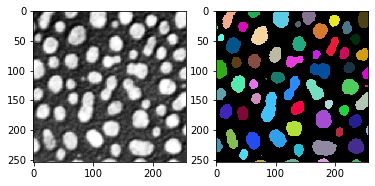

In [2]:
# load intensity image
image = imread('../../data/blobs.tif')

# segment the image
labels = cle.label(cle.threshold_otsu(image))

fig, axs = plt.subplots(1, 2)

cle.imshow(image, color_map="Greys_r", plot=axs[0])
cle.imshow(labels, labels=True, plot=axs[1])

## 训练
我们还需要一个地面真实标注图像。这个图像也是一个具有稀疏标注的标签图像。通过所有应该属于类别`1`的对象画了一条值为`1`的线。通过所有应该被分类为类别`2`的对象画了一条值为`2`的线。如果线穿过背景，这将被忽略。在这个例子中，对象被标注为三个类别：
* 细长的对象
* 圆形对象
* 小对象

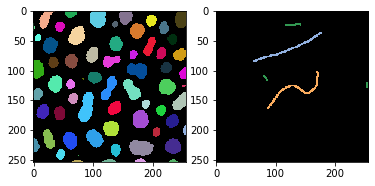

In [3]:
annotation = cle.push(imread('../../data/label_annotation.tif'))

fig, axs = plt.subplots(1, 2)

cle.imshow(labels, labels=True, plot=axs[0])
cle.imshow(annotation, labels=True, plot=axs[1])

接下来，我们需要定义我们想要用于分类对象的特征。我们将使用面积、形状和强度的标准差。

In [4]:
features = 'area mean_max_distance_to_centroid_ratio standard_deviation_intensity'

In [5]:
# Create an object classifier
filename = "../../data/blobs_object_classifier.cl"
classifier = apoc.ObjectClassifier(filename)

# train it; after training, it will be saved to the file specified above
classifier.train(features, labels, annotation, image)

在分类器训练完成后，我们可以立即使用它来预测图像中对象的分类。

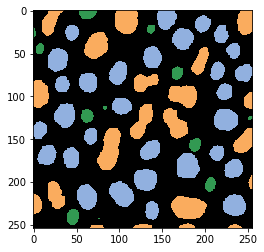

In [6]:
# determine object classification
classification_result = classifier.predict(labels, image)

cle.imshow(classification_result, labels=True)

## 预测
你也可以从磁盘重新加载分类器并将其应用于其他图像。我们将通过旋转原始图像来模拟这一过程。顺便说一下，这是一个很好的健全性检查，可以看看分类是否依赖于图像的方向。

In [7]:
image2 = cle.rotate(image, angle_around_z_in_degrees=90)
labels2 = cle.rotate(labels, angle_around_z_in_degrees=90)

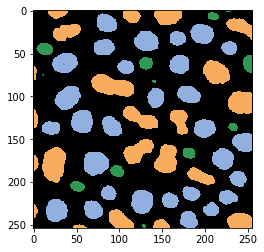

In [8]:
classifier2 = apoc.ObjectClassifier("../../data/blobs_object_classifier.cl")

classification_result2 = classifier2.predict(labels2, image2)

cle.imshow(classification_result2, labels=True)

## 可用于对象分类的特征
我们可以打印出所有可用的特征。带有`?`的参数在该位置期望一个数字，并且可以多次指定多个值。

In [9]:
apoc.list_available_object_classification_features()

['label',
 'original_label',
 'bbox_min_x',
 'bbox_min_y',
 'bbox_min_z',
 'bbox_max_x',
 'bbox_max_y',
 'bbox_max_z',
 'bbox_width',
 'bbox_height',
 'bbox_depth',
 'min_intensity',
 'max_intensity',
 'sum_intensity',
 'area',
 'mean_intensity',
 'sum_intensity_times_x',
 'mass_center_x',
 'sum_intensity_times_y',
 'mass_center_y',
 'sum_intensity_times_z',
 'mass_center_z',
 'sum_x',
 'centroid_x',
 'sum_y',
 'centroid_y',
 'sum_z',
 'centroid_z',
 'sum_distance_to_centroid',
 'mean_distance_to_centroid',
 'sum_distance_to_mass_center',
 'mean_distance_to_mass_center',
 'standard_deviation_intensity',
 'max_distance_to_centroid',
 'max_distance_to_mass_center',
 'mean_max_distance_to_centroid_ratio',
 'mean_max_distance_to_mass_center_ratio',
 'touching_neighbor_count',
 'average_distance_of_touching_neighbors',
 'average_distance_of_n_nearest_neighbors=?',
 'average_distance_of_n_nearest_neighbors=?']